# Проектная работа на тему:
## Сравнительное исследование архитектуры нейронных сетей на примере задачи мультиклассовой классификации изображений

Содержание:
1. Подготовка набора данных
2. Model 0: Создание baseline модели
3. Формирование предсказаний и оценка результатов базовой модели
4. Model 1: Добавление нелинейности в модель
5. Формирование предсказаний и оценка результатов нелинейной модели
6. Model 2: Создание сверточной нейронной сети (CNN)
7. Сравнение результатов всех моделей
8. Построение confusion matrix для лучшей модели
9. Итоговые выводы

## 1. Подготовка набора данных

In [1]:
## Importing libraries
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import torcheval
from torcheval.metrics.functional import multiclass_accuracy, multiclass_f1_score

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

In [2]:
## Setup device agnostic code
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

### Загружаем датасет

In [3]:
## Downloading dataset
train_data = datasets.FashionMNIST(root='data', train=True, transform=ToTensor(), download=True)
test_data = datasets.FashionMNIST(root='data', train=False, transform=ToTensor(), download=True)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
type(train_data[0]), len(train_data[0])

(tuple, 2)

In [6]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [7]:
train_data[0][1]

9

In [8]:
## Let's check class distribution in our dataset
count_train_list = []
count_test_list = []

for i in range(len(train_data)):
    count_train_list.append(train_data[i][1])

for i in range(len(test_data)):
    count_test_list.append(test_data[i][1])

count_train_df = pd.DataFrame({'Train_labels': count_train_list})
count_test_df = pd.DataFrame({'Test_labels': count_test_list})

In [9]:
count_train_df['Train_labels'].value_counts()

Train_labels
9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: count, dtype: int64

In [10]:
count_test_df['Test_labels'].value_counts()

Test_labels
9    1000
2    1000
1    1000
6    1000
4    1000
5    1000
7    1000
3    1000
8    1000
0    1000
Name: count, dtype: int64

Распределение по классам в обучающей и тестовой выборках идеально сбалансировано

In [11]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

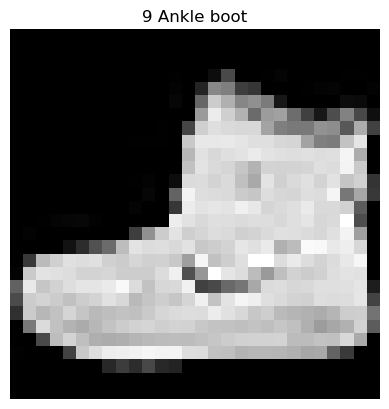

In [12]:
## Let's visualize our data
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='grey')
plt.title(str(label) + ' ' + class_names[label])
plt.axis(False)
plt.show();

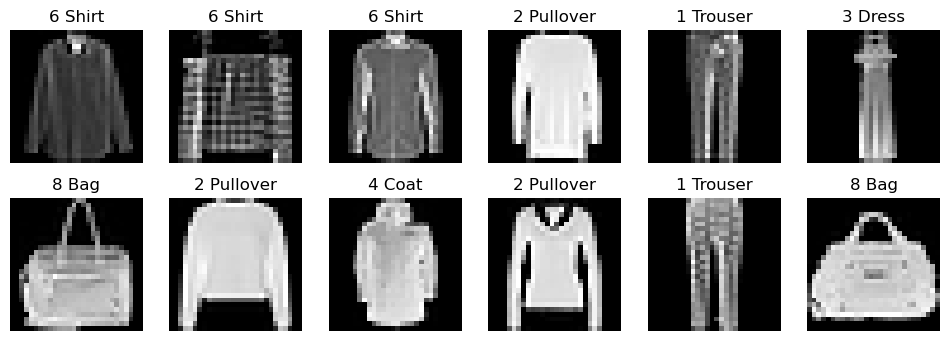

In [13]:
# Let's visualize more images
plt.figure(figsize=(12,4))
for i in range(1, 13, 1):
    idx = torch.randint(low=0, high=len(train_data), size=(1,)).item()
    image, label = train_data[idx]
    plt.subplot(2,6,i)
    plt.title(str(label) + ' ' + class_names[label])
    plt.imshow(image.squeeze(), cmap='grey')
    plt.axis(False)

### Подготовка DataLoader

In [14]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
print(f"Train loader length: {len(train_loader)} batches of {BATCH_SIZE} images")
print(f"Test loader length: {len(test_loader)} batches of {BATCH_SIZE} images")

Train loader length: 1875 batches of 32 images
Test loader length: 313 batches of 32 images


In [16]:
train_images_batch, train_labels_batch = next(iter(train_loader))

In [17]:
train_images_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

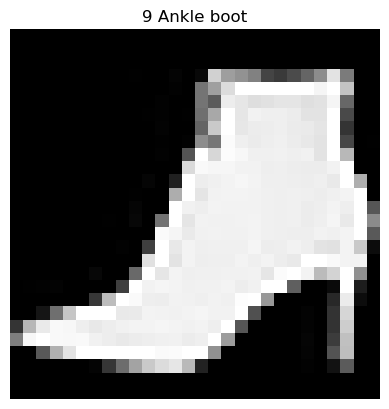

In [18]:
## Let's visualize random image from the first batch
idx = torch.randint(low=0, high=len(train_images_batch), size=(1,)).item()
image, label = train_images_batch[idx], train_labels_batch[idx]
plt.imshow(image.squeeze(), cmap='grey')
plt.title(str(label.item()) + ' ' + class_names[label])
plt.axis(False)
plt.show();

## 2. Построение базовой модели (baseline)

In [19]:
RANDOM_SEED = 13
# RANDOM_SEED = torch.randint(low=0, high=100, size=(1,)).item()  ## Let's have fun
torch.manual_seed(RANDOM_SEED)
RANDOM_SEED

13

In [20]:
## Creating baseline model as a subclass from nn.Module
class LinearModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                         nn.Linear(in_features=input_shape, out_features=hidden_units),
                                         nn.Linear(in_features=hidden_units, out_features=output_shape)
                                        )
    def forward(self, x):
        return self.layer_stack(x)    

In [21]:
torch.manual_seed(RANDOM_SEED)

## Calculating number of pixels for the given image in our dataset
pix_num = train_images_batch[0].shape[1] * train_images_batch[0].shape[2]

## Instantiating our model
model_0 = LinearModelV0(input_shape=pix_num, hidden_units=15, output_shape=len(class_names))

## Sending model to device
model_0.to(device)
model_0

LinearModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=10, bias=True)
  )
)

In [22]:
## Learning rate
lr = 0.0001

## Defining loss function
cross_entropy_loss = nn.CrossEntropyLoss()

## Setting up an optimizer
optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)

## 3. Создаем цикл train/test для базовой модели

In [23]:
torch.manual_seed(RANDOM_SEED)

epochs = 30
epoch_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    ## loop through batches
    train_loss = 0
    for X, y in train_loader:
        ## Sending data to the target device
        X, y = X.to(device), y.to(device)
        ## Training mode
        model_0.train()
        ## Pass forward
        y_pred = model_0(X)
        ## Loss calculate (& evaluation metrics)
        loss = cross_entropy_loss(y_pred, y)
        train_loss += loss
        ## Zero gradient
        optimizer.zero_grad()
        ## Loss backward
        loss.backward()
        ## Step optimizer
        optimizer.step()
        
    ## Calculating train loss per batch
    train_loss /= len(train_loader)

    ### Testing
    # Setting variables for accumulatively adding up loss and evaluation metrics 
    test_loss, test_acc, test_f1 = 0, 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            ## Sending data to the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculating loss (accumatively)
            test_loss += cross_entropy_loss(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculating metrics 
            test_acc += multiclass_accuracy(test_pred, y, num_classes=len(class_names)).item()
            test_f1 += multiclass_f1_score(test_pred, y, num_classes=len(class_names)).item()
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_loader)

        # Divide total test metrics by length of test dataloader (per batch)
        test_acc /= len(test_loader)
        test_f1 /= len(test_loader)

    if epoch % 1 == 0:
        ## Saving intermediate results
        epoch_list.append(epoch)
        train_loss_list.append(train_loss.detach().numpy())
        test_loss_list.append(test_loss.detach().numpy())
        ## Printing intermediate results
        print(f"Epoch: {epoch} | Train loss: {train_loss:.7f} | Test loss: {test_loss:.7f} | Accuracy: {test_acc:.2f} \
| F1-score: {test_f1:.2f}")

Epoch: 0 | Train loss: 1.0544204 | Test loss: 0.7404323 | Accuracy: 0.74 | F1-score: 0.74
Epoch: 1 | Train loss: 0.6509396 | Test loss: 0.6185516 | Accuracy: 0.78 | F1-score: 0.78
Epoch: 2 | Train loss: 0.5687914 | Test loss: 0.5677615 | Accuracy: 0.80 | F1-score: 0.80
Epoch: 3 | Train loss: 0.5269698 | Test loss: 0.5376227 | Accuracy: 0.82 | F1-score: 0.82
Epoch: 4 | Train loss: 0.5008971 | Test loss: 0.5180505 | Accuracy: 0.82 | F1-score: 0.82
Epoch: 5 | Train loss: 0.4827444 | Test loss: 0.5056242 | Accuracy: 0.82 | F1-score: 0.82
Epoch: 6 | Train loss: 0.4693516 | Test loss: 0.4944169 | Accuracy: 0.83 | F1-score: 0.83
Epoch: 7 | Train loss: 0.4592839 | Test loss: 0.4860551 | Accuracy: 0.83 | F1-score: 0.83
Epoch: 8 | Train loss: 0.4511928 | Test loss: 0.4800557 | Accuracy: 0.83 | F1-score: 0.83
Epoch: 9 | Train loss: 0.4441953 | Test loss: 0.4765506 | Accuracy: 0.83 | F1-score: 0.83
Epoch: 10 | Train loss: 0.4385922 | Test loss: 0.4727552 | Accuracy: 0.83 | F1-score: 0.83
Epoch: 11

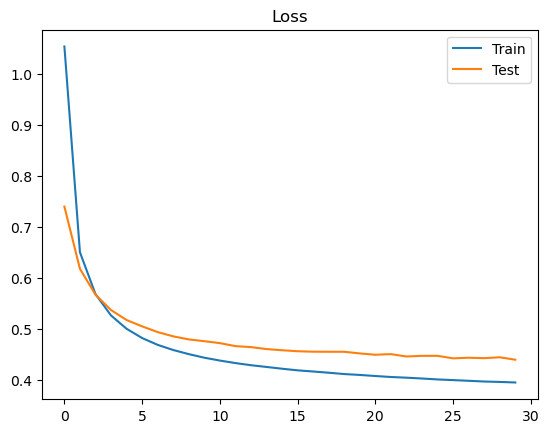

In [24]:
## Plotting loss curves
plt.plot(epoch_list, train_loss_list, label="Train")
plt.plot(epoch_list, test_loss_list, label="Test")

plt.title("Loss")
plt.legend()
plt.show();

### 3.1 Формируем предсказания и сохраняем результаты

In [26]:
#torch.manual_seed(RANDOM_SEED)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               f1_score_fn,
               device: torch.device = device
              ):
    """Returns a list containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        f1_score_fn: A function calculating F1-score to compare the models predictions to the truth labels.

    Returns:
        (list): Results of model making predictions on data_loader.
    """
    loss, accuracy, f1_score = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            ## Sending data to the target device
            X, y = X.to(device), y.to(device)
            
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            accuracy += accuracy_fn(y_pred, y, num_classes=len(class_names))
            f1_score += f1_score_fn(y_pred, y, num_classes=len(class_names))
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        accuracy /= len(data_loader)
        f1_score /= len(data_loader)
        
    return [round(loss.item(), 7), 
            round(accuracy.item(), 4),
            round(f1_score.item(), 4)
           ]

In [27]:
results = {}
model_name = model_0.__class__.__name__ # only works when model was created with a class

# Calculate model 0 results on test dataset
results[model_name] = eval_model(model=model_0, 
                                 data_loader=test_loader,
                                 loss_fn=cross_entropy_loss, 
                                 accuracy_fn=multiclass_accuracy,
                                 f1_score_fn=multiclass_f1_score
                                )

pd.DataFrame(results, index = ['Loss', 'Accuracy', 'F1-score']).T

,Loss,Accuracy,F1-score
LinearModelV0,0.440238,0.8458,0.8458


## 4. Model 1: Добавление нелинейности в модель

In [28]:
## Creating a model with non-linear layers
class NonLinearModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                         nn.Linear(in_features=input_shape, out_features=hidden_units),
                                         nn.ReLU(),
                                         nn.Linear(in_features=hidden_units, out_features=output_shape),
                                         nn.ReLU()
                                        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [29]:
torch.manual_seed(RANDOM_SEED)

## Instatiating our new model
model_1 = NonLinearModelV1(input_shape=pix_num, hidden_units=15, output_shape=len(class_names))

## Sending model to device
model_1.to(device)
model_1

NonLinearModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=15, bias=True)
    (2): ReLU()
    (3): Linear(in_features=15, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [30]:
## Defining loss function
cross_entropy_loss = nn.CrossEntropyLoss()

## Setting up an optimizer
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)

## 5. Создаем цикл train/test для нелинейной модели

In [31]:
torch.manual_seed(RANDOM_SEED)

epochs = 30
epoch_list = []
train_loss_list = []
test_loss_list = []

## Train/eval loop
for epoch in range(epochs):
    ## loop through batches
    train_loss = 0
    for X, y in train_loader:
        ## Sending data to the target device
        X, y = X.to(device), y.to(device)
        ## Training mode
        model_1.train()
        ## Pass forward
        y_pred = model_1(X)
        ## Loss calculate (& evaluation metrics)
        loss = cross_entropy_loss(y_pred, y)
        train_loss += loss
        ## Zero gradient
        optimizer.zero_grad()
        ## Loss backward
        loss.backward()
        ## Step optimizer
        optimizer.step()
        
    ## Calculating train loss per batch
    train_loss /= len(train_loader)

    ### Testing
    # Setting variables for accumulatively adding up loss and evaluation metrics 
    test_loss, test_acc, test_f1 = 0, 0, 0 
    model_1.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            ## Sending data to device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model_1(X)
           
            # 2. Calculating loss (accumatively)
            test_loss += cross_entropy_loss(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculating metrics 
            test_acc += multiclass_accuracy(test_pred, y, num_classes=len(class_names)).item()
            test_f1 += multiclass_f1_score(test_pred, y, num_classes=len(class_names)).item()
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_loader)

        # Divide total test metrics by length of test dataloader (per batch)
        test_acc /= len(test_loader)
        test_f1 /= len(test_loader)

    if epoch % 1 == 0:
        ## Saving intermediate results
        epoch_list.append(epoch)
        train_loss_list.append(train_loss.detach().numpy())
        test_loss_list.append(test_loss.detach().numpy())
        ## Printing intermediate results
        print(f"Epoch: {epoch} | Train loss: {train_loss:.7f} | Test loss: {test_loss:.7f} | Accuracy: {test_acc:.2f} \
| F1-score: {test_f1:.2f}")

Epoch: 0 | Train loss: 1.5591960 | Test loss: 1.2307506 | Accuracy: 0.62 | F1-score: 0.62
Epoch: 1 | Train loss: 1.1571774 | Test loss: 1.1158407 | Accuracy: 0.67 | F1-score: 0.67
Epoch: 2 | Train loss: 1.0827324 | Test loss: 1.0707954 | Accuracy: 0.68 | F1-score: 0.68
Epoch: 3 | Train loss: 1.0464603 | Test loss: 1.0450113 | Accuracy: 0.69 | F1-score: 0.69
Epoch: 4 | Train loss: 1.0242720 | Test loss: 1.0284030 | Accuracy: 0.70 | F1-score: 0.70
Epoch: 5 | Train loss: 1.0088547 | Test loss: 1.0175999 | Accuracy: 0.70 | F1-score: 0.70
Epoch: 6 | Train loss: 0.9973961 | Test loss: 1.0096364 | Accuracy: 0.70 | F1-score: 0.70
Epoch: 7 | Train loss: 0.9887350 | Test loss: 1.0022508 | Accuracy: 0.71 | F1-score: 0.71
Epoch: 8 | Train loss: 0.9815158 | Test loss: 0.9957210 | Accuracy: 0.71 | F1-score: 0.71
Epoch: 9 | Train loss: 0.9754930 | Test loss: 0.9933549 | Accuracy: 0.71 | F1-score: 0.71
Epoch: 10 | Train loss: 0.9704832 | Test loss: 0.9884771 | Accuracy: 0.71 | F1-score: 0.71
Epoch: 11

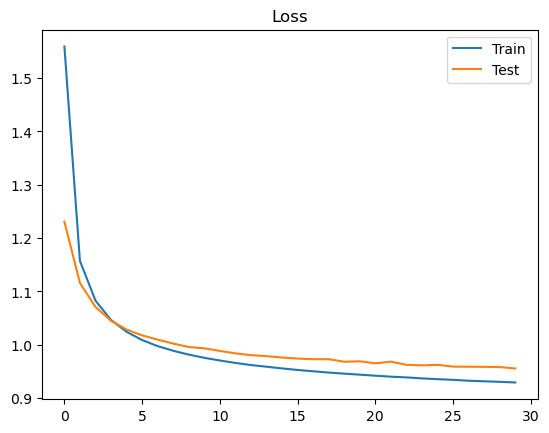

In [32]:
## Plotting loss curves
plt.plot(epoch_list, train_loss_list, label="Train")
plt.plot(epoch_list, test_loss_list, label="Test")

plt.title("Loss")
plt.legend()
plt.show();

### 5.1 Формируем и сохраняем результаты нелинейной модели

In [33]:
model_name = model_1.__class__.__name__ # only works when model was created with a class

# Calculating model 1 results on test dataset
results[model_name] = eval_model(model=model_1, 
                                 data_loader=test_loader,
                                 loss_fn=cross_entropy_loss, 
                                 accuracy_fn=multiclass_accuracy,
                                 f1_score_fn=multiclass_f1_score
                                )

pd.DataFrame(results, index = ['Loss', 'Accuracy', 'F1-score']).T

,Loss,Accuracy,F1-score
LinearModelV0,0.440238,0.8458,0.8458
NonLinearModelV1,0.955542,0.7240,0.7240


## 6. Model 2: Построение сверточной нейронной сети (CNN)

Архитектура сверточной сети под названием TinyVGG взята с сайта [CNN Explainer](https://poloclub.github.io/cnn-explainer/)
<img src="cnn_architecture.png" width=600>

In [34]:
# Creating a convolutional neural network 
class CNNModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [35]:
torch.manual_seed(RANDOM_SEED)

model_2 = CNNModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)

model_2

CNNModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [36]:
## Defining loss function
cross_entropy_loss = nn.CrossEntropyLoss()

## Setting up an optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)

### 6.1 Создаем цикл train/test для CNN модели

In [37]:
torch.manual_seed(RANDOM_SEED)

epochs = 30
epoch_list = []
train_loss_list = []
test_loss_list = []

## Train/eval loop
for epoch in range(epochs):
    ## loop through batches
    train_loss = 0
    for X, y in train_loader:
        ## Senfing data to device
        X, y = X.to(device), y.to(device)
        ## Training mode
        model_2.train()
        ## Pass forward
        y_pred = model_2(X)
        ## Loss calculate (& evaluation metrics)
        loss = cross_entropy_loss(y_pred, y)
        train_loss += loss
        ## Zero gradient
        optimizer.zero_grad()
        ## Loss backward
        loss.backward()
        ## Step optimizer
        optimizer.step()
        
    ## Calculating train loss per batch
    train_loss /= len(train_loader)

    ### Testing
    # Setting variables for accumulatively adding up loss and evaluation metrics 
    test_loss, test_acc, test_f1 = 0, 0, 0 
    model_2.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            ## Sendiing data to device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model_2(X)
           
            # 2. Calculating loss (accumatively)
            test_loss += cross_entropy_loss(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculating metrics 
            test_acc += multiclass_accuracy(test_pred, y, num_classes=len(class_names)).item()
            test_f1 += multiclass_f1_score(test_pred, y, num_classes=len(class_names)).item()
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_loader)

        # Divide total test metrics by length of test dataloader (per batch)
        test_acc /= len(test_loader)
        test_f1 /= len(test_loader)

    if epoch % 1 == 0:
        ## Saving intermediate results
        epoch_list.append(epoch)
        train_loss_list.append(train_loss.detach().numpy())
        test_loss_list.append(test_loss.detach().numpy())
        ## Printing intermediate results
        print(f"Epoch: {epoch} | Train loss: {train_loss:.7f} | Test loss: {test_loss:.7f} | Accuracy: {test_acc:.2f} \
| F1-score: {test_f1:.2f}")

Epoch: 0 | Train loss: 0.9865122 | Test loss: 0.6429261 | Accuracy: 0.77 | F1-score: 0.77
Epoch: 1 | Train loss: 0.5630524 | Test loss: 0.5341225 | Accuracy: 0.80 | F1-score: 0.80
Epoch: 2 | Train loss: 0.4860751 | Test loss: 0.4894668 | Accuracy: 0.82 | F1-score: 0.82
Epoch: 3 | Train loss: 0.4493482 | Test loss: 0.4566966 | Accuracy: 0.84 | F1-score: 0.84
Epoch: 4 | Train loss: 0.4281155 | Test loss: 0.4409809 | Accuracy: 0.84 | F1-score: 0.84
Epoch: 5 | Train loss: 0.4146797 | Test loss: 0.4323888 | Accuracy: 0.85 | F1-score: 0.85
Epoch: 6 | Train loss: 0.4024324 | Test loss: 0.4268695 | Accuracy: 0.85 | F1-score: 0.85
Epoch: 7 | Train loss: 0.3930664 | Test loss: 0.4030936 | Accuracy: 0.86 | F1-score: 0.86
Epoch: 8 | Train loss: 0.3837513 | Test loss: 0.4034469 | Accuracy: 0.86 | F1-score: 0.86
Epoch: 9 | Train loss: 0.3746582 | Test loss: 0.3932504 | Accuracy: 0.86 | F1-score: 0.86
Epoch: 10 | Train loss: 0.3686735 | Test loss: 0.4040554 | Accuracy: 0.85 | F1-score: 0.85
Epoch: 11

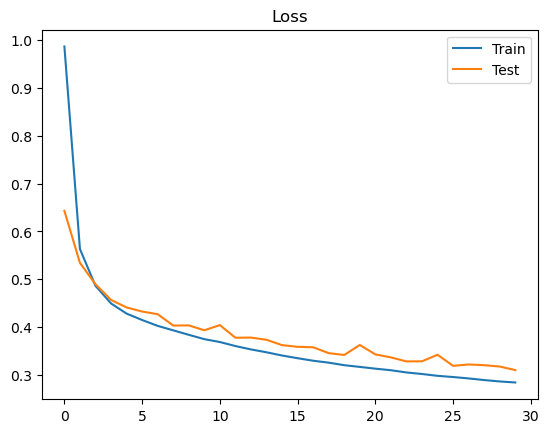

In [38]:
## Plotting loss curves
plt.plot(epoch_list, train_loss_list, label="Train")
plt.plot(epoch_list, test_loss_list, label="Test")

plt.title("Loss")
plt.legend()
plt.show();

### 6.2 Формируем и сохраняем результаты CNN модели

In [39]:
model_name = model_2.__class__.__name__ # only works when model was created with a class

# Calculating CNN model results on test dataset
results[model_name] = eval_model(model=model_2, 
                                 data_loader=test_loader,
                                 loss_fn=cross_entropy_loss, 
                                 accuracy_fn=multiclass_accuracy,
                                 f1_score_fn=multiclass_f1_score
                                )

## 7. Сравнение результатов моделей

In [40]:
pd.DataFrame(results, index = ['Loss', 'Accuracy', 'F1-score']).T

,Loss,Accuracy,F1-score
LinearModelV0,0.440238,0.8458,0.8458
NonLinearModelV1,0.955542,0.7240,0.7240
CNNModelV2,0.309998,0.8896,0.8896


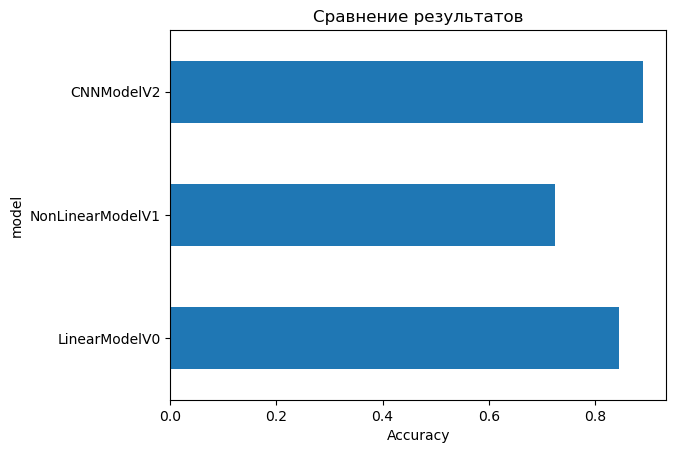

In [41]:
# Visualizing our model results
compare_results = pd.DataFrame(results, index = ['Loss', 'Accuracy', 'F1-score']).T
compare_results["Accuracy"].plot(kind="barh")
plt.title("Сравнение результатов")
plt.xlabel("Accuracy")
plt.ylabel("model");

### 7.1 Визуализируем несколько случайно выбранных предсказаний CNN модели

In [42]:
## let's create a function where we can pass the model and some data for it to predict on
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [43]:
random.seed(RANDOM_SEED)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 8 (Bag)


In [44]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[2.3019e-05, 6.3280e-12, 6.7936e-07, 1.0641e-09, 3.9736e-09, 1.1071e-07,
         2.4814e-05, 1.1669e-08, 9.9995e-01, 1.0640e-07],
        [5.4639e-02, 8.8973e-05, 5.9324e-03, 3.3359e-01, 8.9632e-04, 1.4043e-07,
         5.6780e-01, 2.1645e-13, 3.7057e-02, 6.8717e-11]])

In [45]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 6, 5, 4, 7, 1, 5, 1, 3])

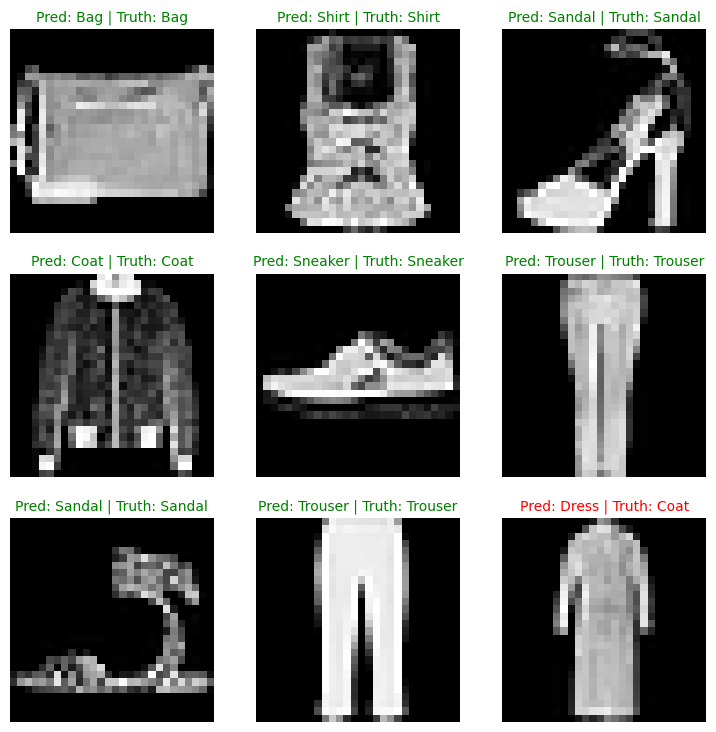

In [46]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## 8. Построение confusion matrix для CNN модели 

In [47]:
# Making predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in test_loader:
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

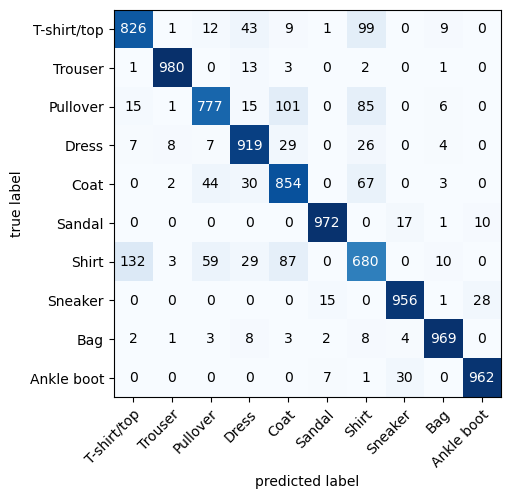

In [48]:
# Setting up confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(5, 6)
);

Мы видим, что CNN модель работает достаточно хорошо, учитывая, что почти все наибольшие значения расположены на главной диагонали (идеальная модель будет иметь значения только на главной диагонали, а все остальные значения будут нулевыми).

Сложности с классификацией у модели возникают на схожих классах, например, с предсказанием "Shirt" для изображений имеющих метку "T-shirt/top" или "Pullover" для изображений, размеченных как "Coat".

## 9. Итоговые выводы

- Сверточная нейронная сеть продемонстрировала ожидаемо лучший результат. Accuracy ~89% для пары десятков строк кода создания модели на PyTorch - неплохой результат, на мой взгляд;
- Результат baseline модели не намного хуже, поэтому при решении конкретной задачи имеет смысл начинать эксперименты с самой простой модели;
- Нелинейная модель показала худший результат и это стоит учитывать при машинном обучении: иногда то, что должно работать, не работает, а то, что, казалось бы, не сработает, работает... ML это частично наука, а остальное - искусство )